# Sentiment Analysis Coursework - Lewis N Watson - 40432878

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
import gensim.downloader as api
np.random.seed(7)

In [2]:
def filter_stopwords(arr):
    print("Filtering stopwords...")
    stopwords = ['stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'i', 'so', 'that', 'had', 'on', 'for', 'were',
                 'was', 'of', 'as', 'an']
    newArr = np.array([])

    for sentences in arr:
        new_sentence = ""
        word_count = 0
        for word in sentences.split():
            if word not in stopwords:
                if word_count == 0:
                    new_sentence += word
                    word_count += 1
                else:
                    new_sentence += " " + word
                    word_count += 1

        if new_sentence != "":
            newArr = np.append(newArr, new_sentence)

    return newArr

In [3]:
def load_data(filename):
    print("Loading data...")
    df = pd.read_csv(filename, names=['sentence', 'label'], sep=',')

    X_raw = df['sentence'].values
    y_raw = df['label'].values

    X_raw = filter_stopwords(X_raw)

    return X_raw, y_raw

In [5]:
# Load data
X_train, y_train = load_data('train.csv')
X_test, y_test = load_data('test.csv')
X_val, y_val = load_data('val.csv')

Loading data...
Filtering stopwords...
Loading data...
Filtering stopwords...
Loading data...
Filtering stopwords...


In [7]:
# Load word2vec model
word2vec_model = api.load("glove-wiki-gigaword-300")

In [8]:
embedding_matrix = word2vec_model.vectors
print('Embedding matrix shape: ', embedding_matrix.shape)
top_words = embedding_matrix.shape[0]
mxlen = 50

Embedding matrix shape:  (400000, 300)


In [9]:
# Tokenize and to sequences
tokenizer = Tokenizer(num_words=top_words,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index

In [10]:
# Pad sequences
X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

In [11]:
# Hyperparameters to fiddle with
batch_size = 8
nb_epoch = 12

In [12]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                weights=[embedding_matrix],
                                trainable=False)

In [13]:
# Build model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, recurrent_dropout=0.1, dropout=0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))  # try softmax for categorical_crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         120000000 
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 120,160,501
Trainable params: 160,501
Non-trainable params: 120,000,000
_________________________________________________________________


In [14]:
# Compile and train model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,validation_data=(X_val, y_val))

Epoch 1/12
175/175 [==============================] - 31s 158ms/step - loss: 0.7095 - accuracy: 0.5043 - val_loss: 0.6834 - val_accuracy: 0.5700
Epoch 2/12
175/175 [==============================] - 27s 155ms/step - loss: 0.6556 - accuracy: 0.6157 - val_loss: 0.6802 - val_accuracy: 0.5700
Epoch 3/12
175/175 [==============================] - 27s 156ms/step - loss: 0.6094 - accuracy: 0.6771 - val_loss: 0.7255 - val_accuracy: 0.5200
Epoch 4/12
175/175 [==============================] - 31s 177ms/step - loss: 0.5535 - accuracy: 0.7321 - val_loss: 0.7260 - val_accuracy: 0.5600
Epoch 5/12
175/175 [==============================] - 32s 181ms/step - loss: 0.4739 - accuracy: 0.7764 - val_loss: 0.7470 - val_accuracy: 0.5800
Epoch 6/12
175/175 [==============================] - 35s 199ms/step - loss: 0.3991 - accuracy: 0.8193 - val_loss: 0.8494 - val_accuracy: 0.5750
Epoch 7/12
175/175 [==============================] - 30s 174ms/step - loss: 0.3033 - accuracy: 0.8793 - val_loss: 0.9176 - val_ac

In [15]:
# Evaluate model
print("Evaluating model...\n")
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy * 100))
print("Training Loss:  {:.4f}".format(loss * 100))

print("") # New Line...

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy*100))
print("Testing Loss:  {:.4f}".format(loss * 100))

Evaluating model...

Training Accuracy: 99.7143
Training Loss:  2.2998

Testing Accuracy:  56.0000
Testing Loss:  130.0217


In [16]:
def plot_valloss_vs_train_accuracy(training):
    plt.plot(training.history['val_loss'], label='Validation Loss')
    plt.plot(training.history['accuracy'], label='Training Accuracy')
    plt.title('Sentiment Analysis - Validation loss vs Training Accuracy')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(loc="lower right")
    plt.show()

def plot_accuracy(training):
    plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(training.history['accuracy'], label='Training Accuracy')
    plt.title('Sentiment Analysis - Training vs Validation Accuracy')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(loc="lower right")
    plt.show()

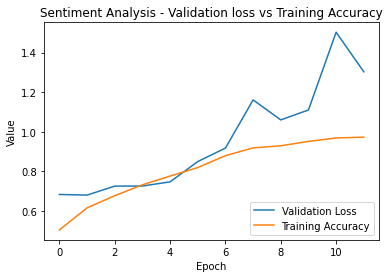

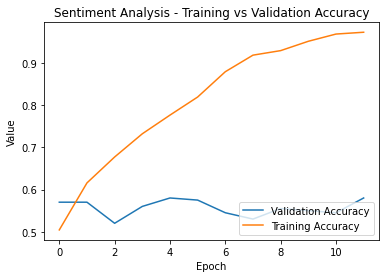

In [17]:
# Plot Charts
plot_valloss_vs_train_accuracy(rnn)
plot_accuracy(rnn)